/var/folders/94/8b3jmj1x6tbdx6dh5b9pb_9c0000gn/T/ipykernel_27502/3101316202.py:4: DeprecationWarning: The "ibm_quantum" channel option is deprecated and will be sunset on 1 July. After this date, "ibm_cloud", "ibm_quantum_platform", and "local" will be the only valid channels. Open Plan users should migrate now.  All other users should review the migration guide (https://quantum.cloud.ibm.com/docs/migration-guides/classic-iqp-to-cloud-iqp)to learn when to migrate.
  service = QiskitRuntimeService()
/var/folders/94/8b3jmj1x6tbdx6dh5b9pb_9c0000gn/T/ipykernel_27502/3101316202.py:24: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 3.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  for instr, qargs, _ in transpiled:


ECR Gates Used After Transpilation:
  • ecr[4,15]: 0.00550
  • ecr[6,5]: 0.00506
  • ecr[4,5]: 0.00404
  • ecr[6,7]: 0.00406

Total ECR Error Rate: 0.01866
Average ECR Error Rate: 0.00466
Depth: 141


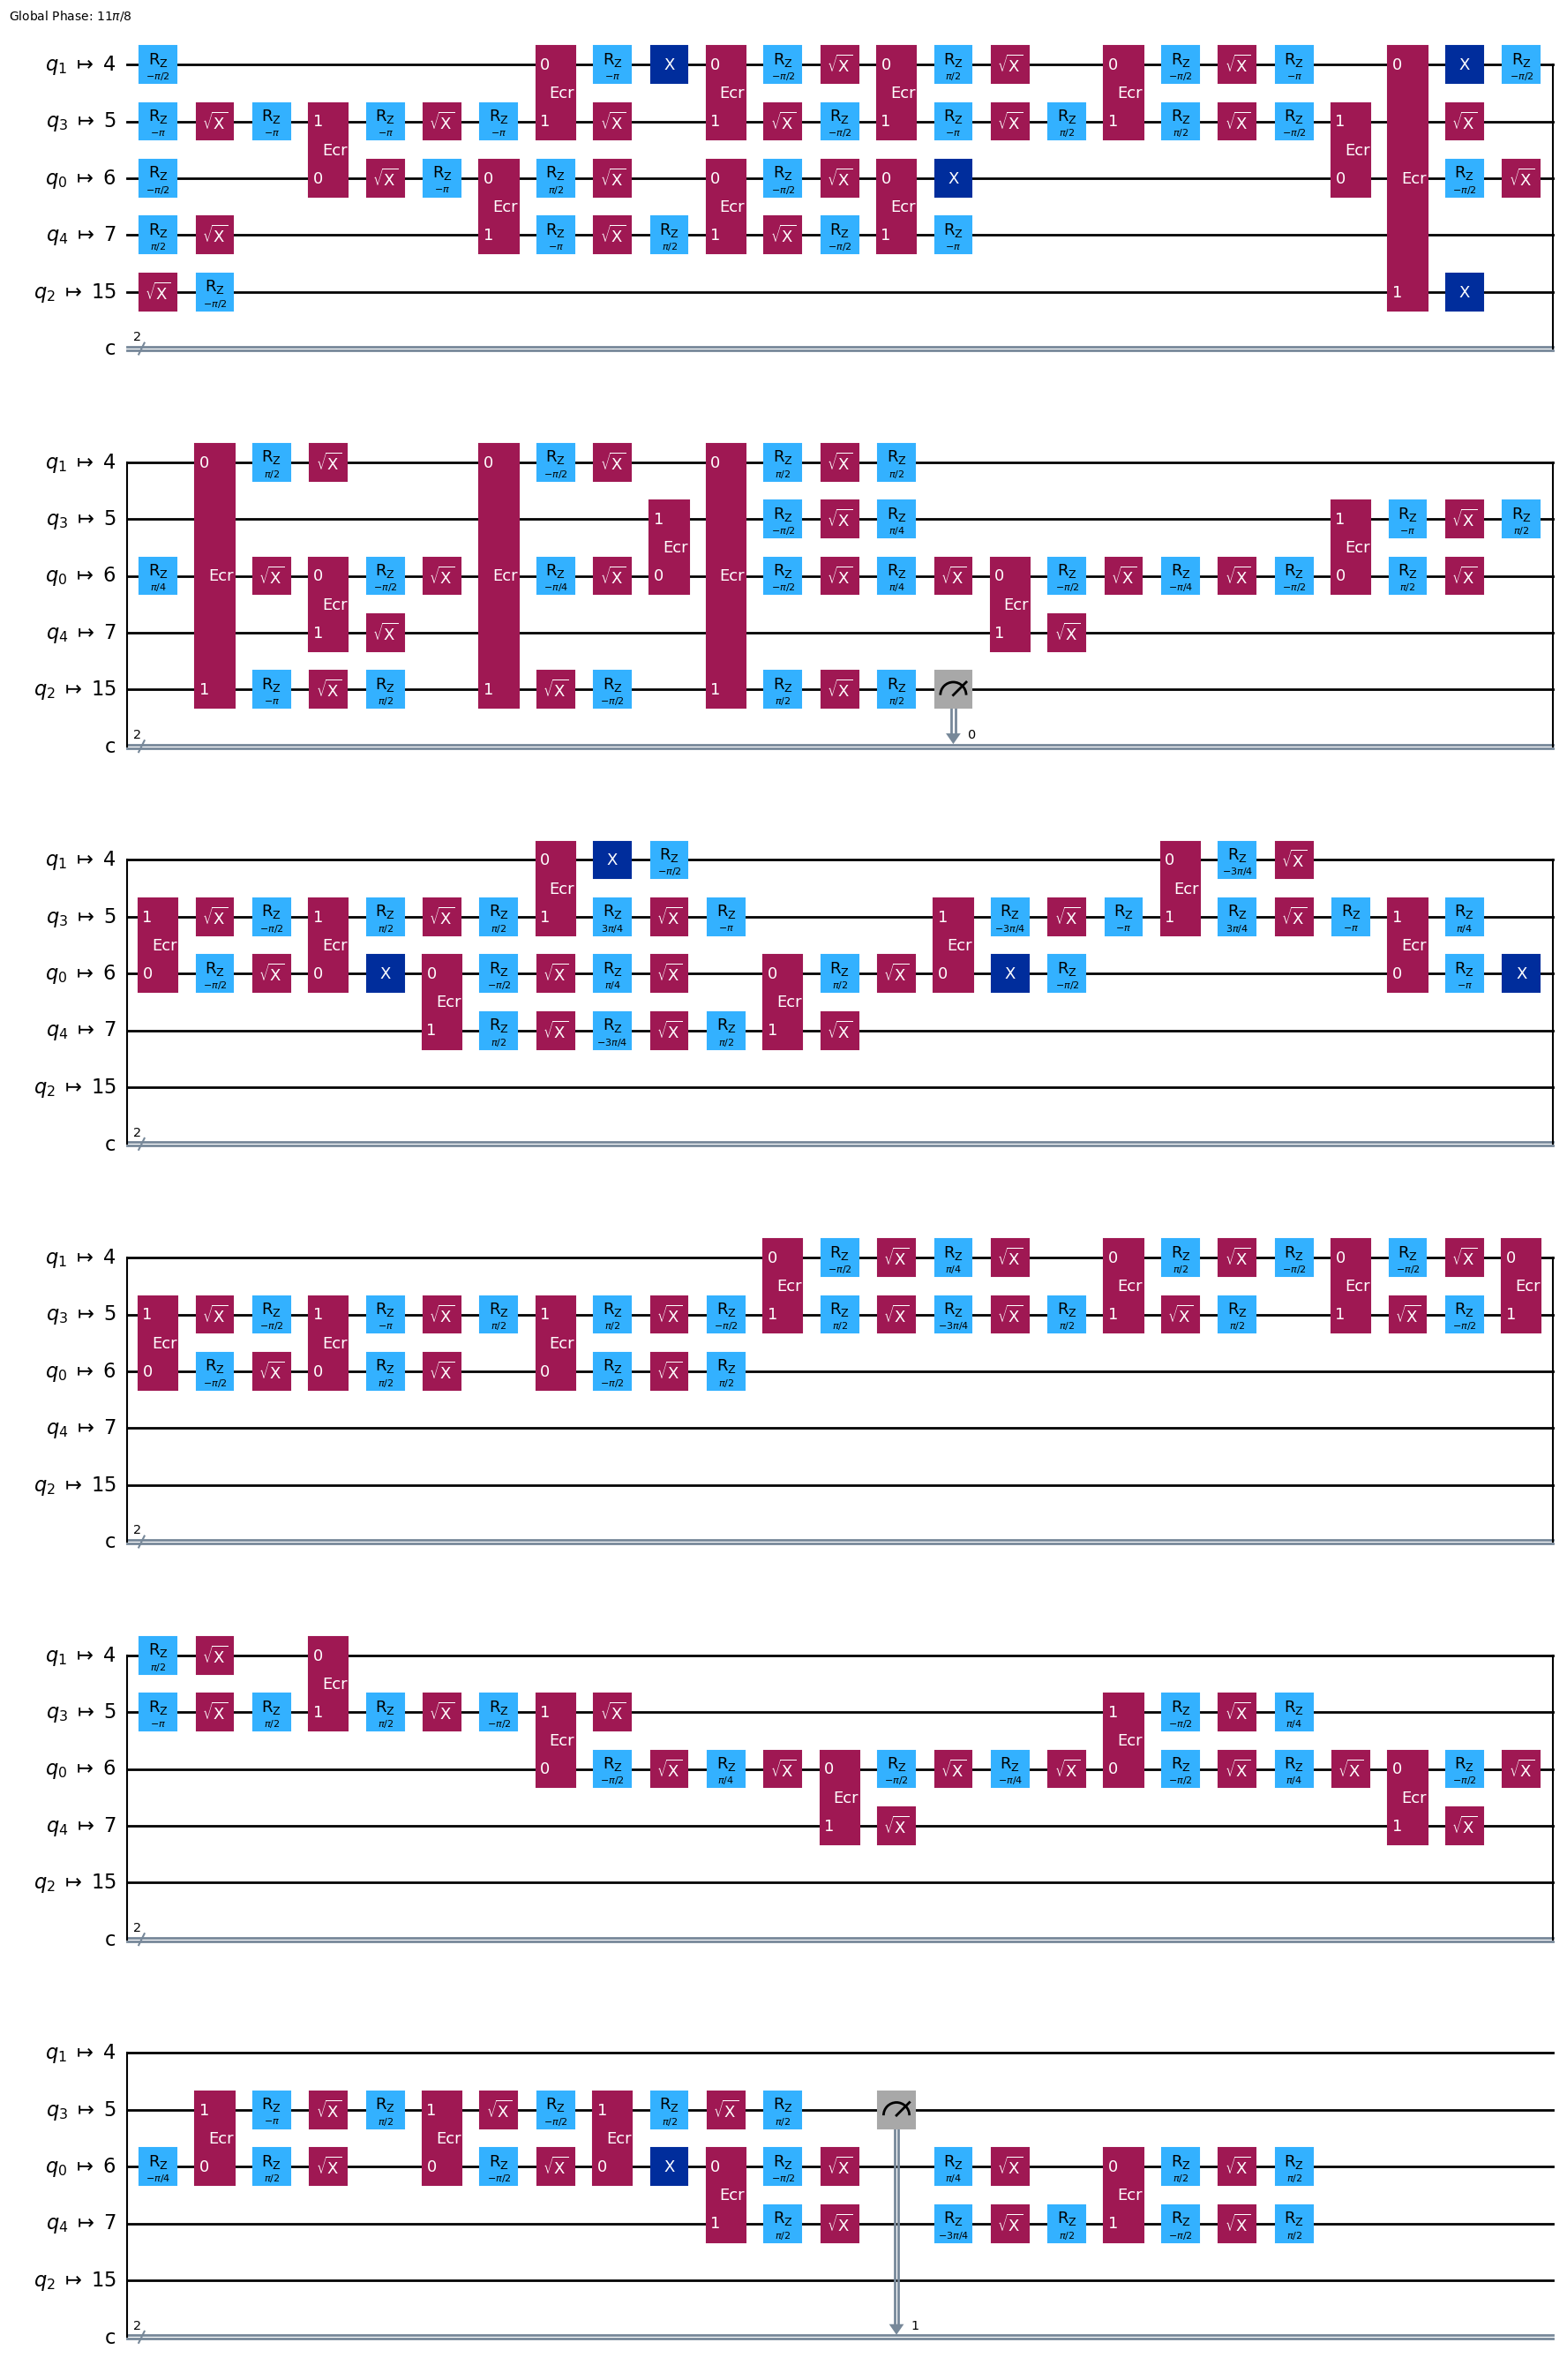

In [8]:
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile

service = QiskitRuntimeService()
backend = service.backend("ibm_brisbane") 
props = backend.properties()

qr = QuantumRegister(5, 'q')
cr = ClassicalRegister(2, 'c')
qc = QuantumCircuit(qr, cr)

qc.cx(qr[0], qr[3])
qc.cx(qr[1], qr[3])
qc.cx(qr[2], qr[3])
qc.ccx(qr[0], qr[1], qr[4])
qc.ccx(qr[1], qr[2], qr[4])
qc.ccx(qr[0], qr[2], qr[4])
qc.measure(qr[3], cr[0])
qc.measure(qr[4], cr[1])

transpiled = transpile(qc, backend=backend, optimization_level=1)

used_ecr = set()
for instr, qargs, _ in transpiled:
    if instr.name == 'ecr':
        pair = tuple(sorted([q._index for q in qargs])) 
        used_ecr.add(pair)

ecr_error_total = 0
ecr_error_list = []

for gate in props.gates:
    if gate.gate == "ecr":
        qubits = tuple(gate.qubits)
        if tuple(sorted(qubits)) in used_ecr:
            for param in gate.parameters:
                if param.name == "gate_error":
                    ecr_error_total += param.value
                    ecr_error_list.append((qubits, param.value))

print("ECR Gates Used After Transpilation:")
for qubits, error in ecr_error_list:
    print(f"  • ecr[{qubits[0]},{qubits[1]}]: {error:.5f}")

avg_error = sum(err for _, err in ecr_error_list) / len(ecr_error_list) if ecr_error_list else 0

print(f"\nTotal ECR Error Rate: {ecr_error_total:.5f}")
print(f"Average ECR Error Rate: {avg_error:.5f}")
print(f"Depth: {transpiled.depth()}")

transpiled.draw('mpl')